In [17]:
from dataset import Dataset
from scipy import stats
import numpy as np
import pandas as pd
import vectorbt as vbt
from analyse_candle import create_target_names
import warnings
warnings.simplefilter(action='ignore')


In [2]:
data_binance = Dataset().get_data(days=400, ticker='BTCUSDT', ts='6h')

In [6]:
data = data_binance.copy()
data['chg'] = data['close'].pct_change()
target_names = create_target_names(data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='chg', ylabel='expected_chg_1'>

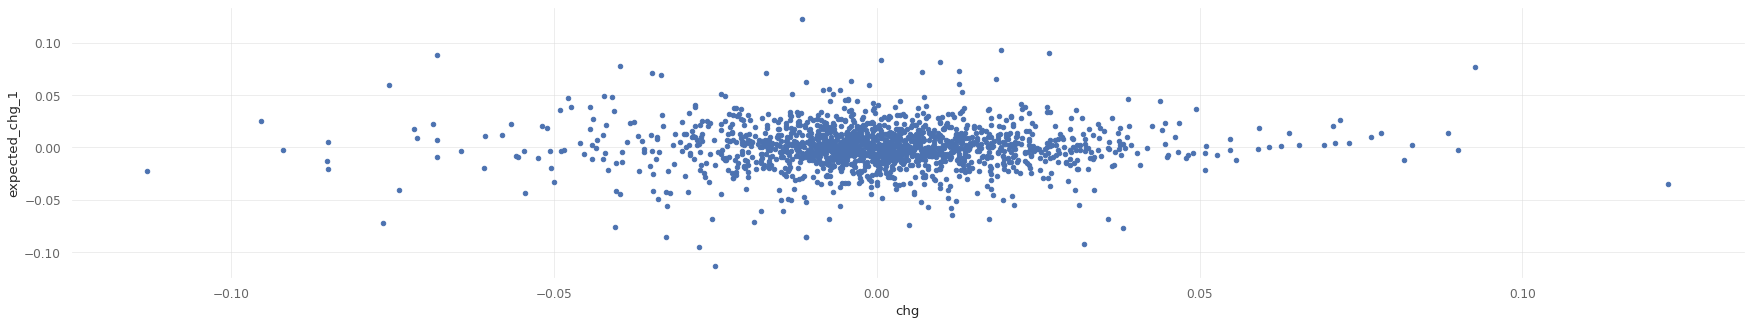

In [11]:
data[['chg', 'expected_chg_1']].plot.scatter(
    x='chg', y='expected_chg_1', figsize=(30, 5)
)

## Test ideas between two range

<AxesSubplot:xlabel='time'>

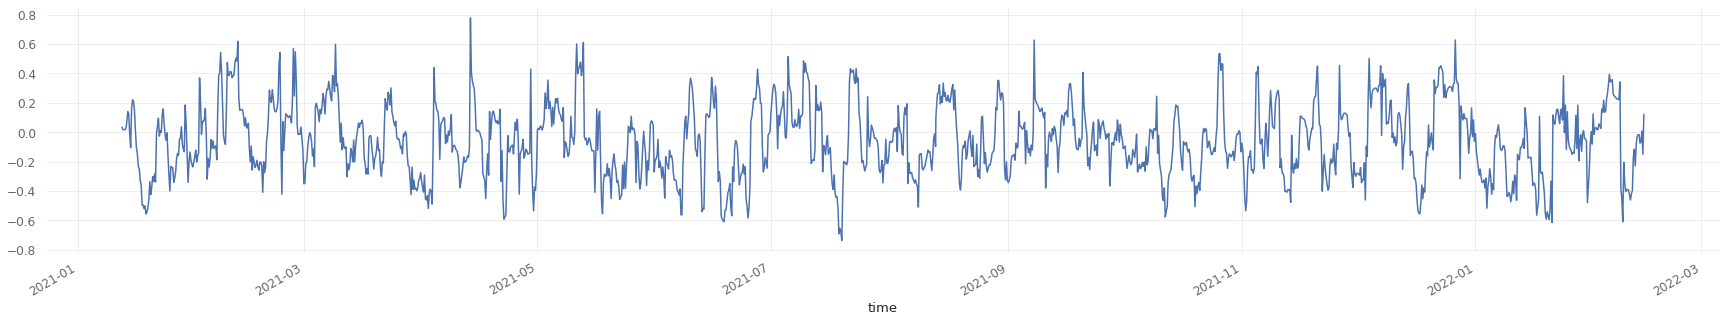

In [12]:
data['corr'] = data['chg'].rolling(12).corr(data['chg'].shift(1))
data['cuts_corr'] = pd.cut(data['corr'], bins=12, labels=False)
data['corr'].plot(figsize=(30, 5))

 0.0    0.845387
 1.0    0.080424
-1.0    0.074190
Name: signal, dtype: float64


<AxesSubplot:xlabel='time'>

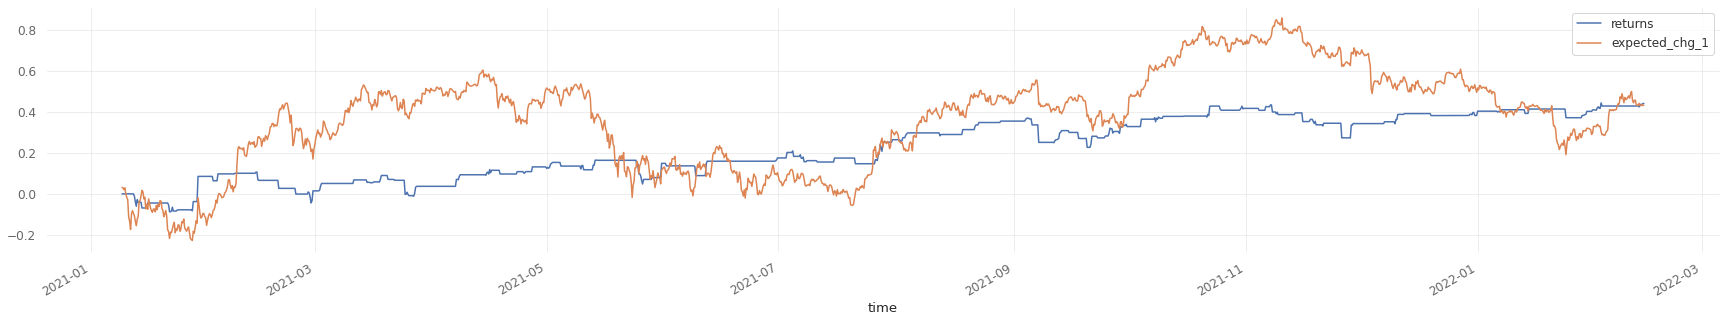

In [15]:
data['signal'] = 0
data['signal'] = np.where(
    (data['corr'] >= -0.05) &
    (data['corr'] <= 0.05),
    np.sign(data['chg']) / -1, data['signal'])
data['returns'] = data['expected_chg_1'] * data['signal']
print(data['signal'].value_counts(True))
data[['returns', 'expected_chg_1']].cumsum().plot(figsize=(30, 5))


<AxesSubplot:>

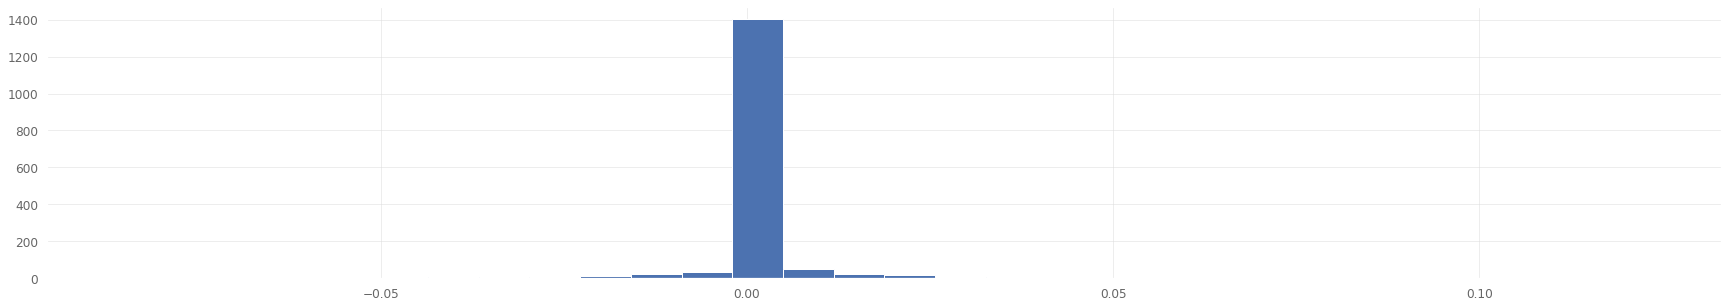

In [16]:
data['returns'].hist(bins=30, figsize=(30, 5))

In [18]:
def t_statistic(xs, ys):
    r = xs.corr(ys)
    df = xs.count() - 2
    return r * np.sqrt(df / 1 - r ** 2)


def calculate_stat(xs, ys):
    t_value = t_statistic(xs, ys)
    df = xs.count() - 2
    p = 2 * stats.t.sf(t_value, df)
    return {'t-stat': t_value, 'p-value': p}

hypotesis_test = calculate_stat(data['returns'], data['expected_chg_1'])
print(hypotesis_test)

{'t-stat': 5.3903863681859265, 'p-value': 8.080135629119224e-08}


## Test ideas using cuts from pandas

In [19]:
data\
    .groupby(['cuts_corr'])['expected_chg_1']\
    .agg(['mean', 'sum'])

,mean,sum
cuts_corr,,
0.0,-0.014167,-0.070833
1.0,-0.002292,-0.114585
2.0,-0.001116,-0.127259
3.0,-0.001703,-0.383210
4.0,0.001888,0.583250
5.0,0.000682,0.214727
6.0,0.001668,0.423764
7.0,-0.001416,-0.225154
8.0,0.001908,0.194574


 1.0    0.534298
-1.0    0.465702
Name: returns, dtype: float64


<AxesSubplot:xlabel='time'>

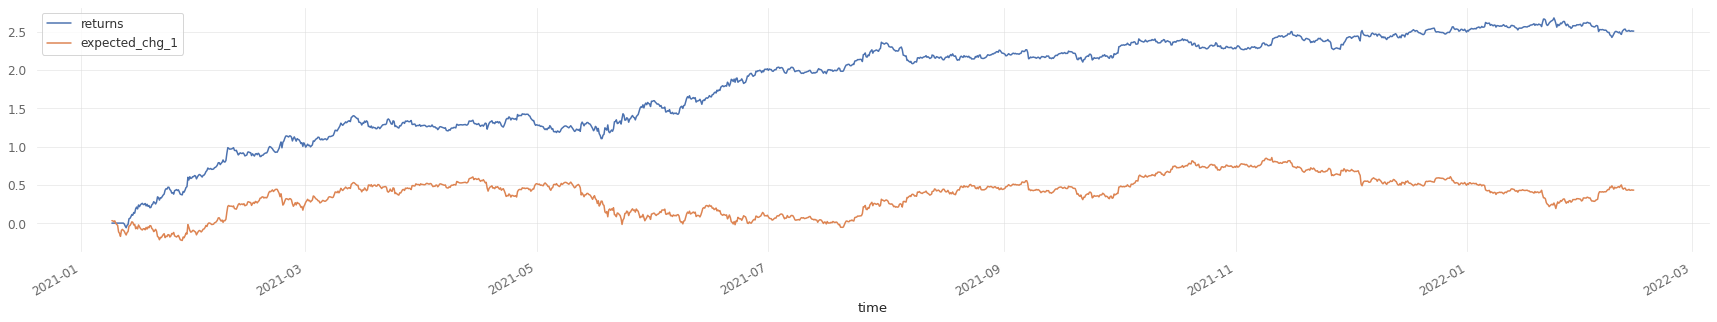

In [24]:
data['signal'] = 0
data['signal'] = np.where(
    data['cuts_corr'].isin([4, 5, 6, 8, 10]),
    1,
    data['signal']
)
data['signal'] = np.where(
    data['cuts_corr'].isin([0, 1, 2, 3, 7, 9]),
    -1,
    data['signal']
)
data['returns'] = data['expected_chg_1'] * data['signal']
print(np.sign(data[data['returns'] != 0]['returns']).value_counts(True))
data[['returns', 'expected_chg_1']].cumsum().plot(figsize=(30, 5))


In [25]:
hypotesis_test = calculate_stat(data['returns'], data['expected_chg_1'])
print(hypotesis_test)

{'t-stat': 8.25809197970159, 'p-value': 3.0621710822951825e-16}


In [30]:
data['entries'] = np.where(data['signal'] == 1, True, False)
data['exits'] = np.where(data['signal'].shift(1), True, False)
data['short_entries'] = np.where(data['signal'] == -1, True, False)
data['short_exits'] = np.where(data['signal'].shift(1) == -1, True, False)

pf = vbt.Portfolio.from_signals(
    close=data['close'],
    entries=data['entries'],
    exits=data['exits'],
    short_entries=data['short_entries'],
    short_exits=data['short_exits'],
)

pf.plot().show()

In [28]:
pf.stats()

Start                         2021-01-09 06:00:00
End                           2022-02-14 00:00:00
Period                                       1604
Start Value                                 100.0
End Value                              259.286959
Total Return [%]                       159.286959
Benchmark Return [%]                     7.721902
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        26.012691
Max Drawdown Duration                       670.0
Total Trades                                  195
Total Closed Trades                           195
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            52.820513
Best Trade [%]                          15.989232
Worst Trade [%]                         -9.387643
Avg Winning Trade [%]                    3.099516
Avg Losing Trade [%]                    -2.280233
